# Analyse de la varicelle

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import numpy as np

Recherche des données sur le site du [Réseau Sentinelles](http://www.sentiweb.fr/) 

In [3]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"
data_file = "syndrome-varicelle.csv"

import os
import urllib.request
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

Description du fichier ([source](http://www.sentiweb.fr/france/fr/?page=table&maladie=7))

|Name |	Type 	| 	Description|
|-|-|-|
|week |	integer |ISO8601 Yearweek number as numeric (year*100 + week nubmer)|
|geo_insee|string |Identifier of the geographic area, from INSEE https://www.insee.fr| |
|geo_name| 	string| 		Geographic label of the area, corresponding to INSEE code. This label is not an id and is only provided for human reading|
|indicator| integer |Unique identifier of the indicator, see metadata document https://www.sentiweb.fr/meta.json |
|inc |	integer 	|	Estimated incidence value for the time step, in the geographic level|
|inc_low |	integer |		Lower bound of the estimated incidence 95% Confidence Interval|
|inc_up |	integer |		Upper bound of the estimated incidence 95% Confidence Interval|
|inc100 |	integer |		Estimated rate incidence per 100,000 inhabitants|
|inc100_low |	integer |		Lower bound of the estimated incidence 95% Confidence Interval|
|inc100_up| 	integer| 		Upper bound of the estimated rate incidence 95% Confidence Interval|
|Missing value| \- | \- |

In [31]:
raw_data = pd.read_csv(data_file, skiprows=1)
raw_data.iloc[np.r_[0:5, -5:0]]

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202012          7   8639     6010   11268      13           9   
1     202011          7  10209     7575   12843      16          12   
2     202010          7   9011     6691   11331      14          10   
3     202009          7  13631    10544   16718      21          16   
4     202008          7  10424     7708   13140      16          12   
1524  199101          7  15565    10271   20859      27          18   
1525  199052          7  19375    13295   25455      34          23   
1526  199051          7  19080    13807   24353      34          25   
1527  199050          7  11079     6660   15498      20          12   
1528  199049          7   1143        0    2610       2           0   

      inc100_up geo_insee geo_name  
0            17        FR   France  
1            20        FR   France  
2            18        FR   France  
3            26        FR   France  
4            20        FR   France  
1524         36        FR   France  
1525         45        FR   France  
1526         43        FR   France  
1527         28        FR   France  
1528          5        FR   France

Recherche de missing data

In [32]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Conversion des dates du format isoweek -> period

In [34]:
data = raw_data

def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Tri par ordre chornologique et vérification de la durée entre 2 observations

In [36]:
sorted_data = data.set_index('period').sort_index()

periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Plot des données 

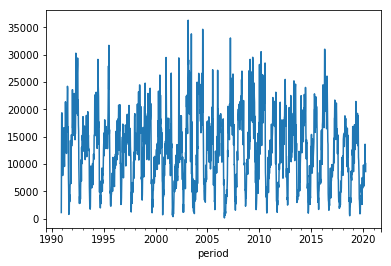

In [41]:
sorted_data['inc'].plot();

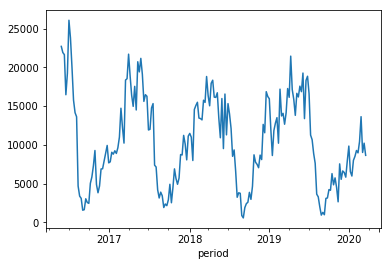

In [43]:
sorted_data['inc'][-200:].plot();

Etude de l'incidence annuelle

La cyclicité des incidences de varicelle est minimum vers le mois de septembre. Cette date est donc le point de départ d'une année 'varicelle'. 

In [46]:
first_sept_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(sorted_data.index[0].year,
                                    sorted_data.index[-1].year)]

Verification de la durée des années 'varicelles'.

In [47]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_sept_week[:-1],
                        first_sept_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

AssertionError: 

La première et dernière année sont incomplètes, on les retire de l'étude.

In [56]:
first_sept_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(sorted_data.index[0].year+1,
                                    sorted_data.index[-1].year-1)]
year = []
yearly_incidence = []
for week1, week2 in zip(first_sept_week[:-1],
                        first_sept_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Plot du nb de cas par année

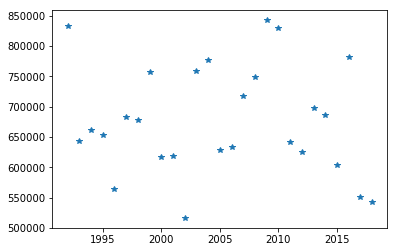

In [60]:
yearly_incidence.plot(style='*')

Table classée du nombre de cas par année

In [63]:
yearly_incidence.sort_values()

2002    516689
2018    542312
2017    551041
1996    564901
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

Distribution du nombre de cas par année

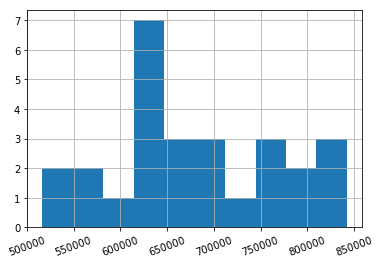

In [64]:
yearly_incidence.hist(xrot=20)